# Wohns et al. 2022 - Midpoint (Averaging Up)

We will use the filtered ARG from the continuous space SLiM simulation notebook (2_ContinuousSpace_WithSLiM.ipynb). This method works best with the standard `simplify()` as recombination nodes lead to artifacts in estimates. Starting at the tips, each parent is set to the average location of it's children.

In [2]:
import tskit
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tskit_arg_visualizer as argviz

ts = tskit.load("continuous_space_ten_samples.trees")
ts_simple = ts.simplify()

In [3]:
def calc_midpoint_node_locations(ts, weighted=True):
    """Estimates node locations using averaging-up method

    Parent node location is the average of its children, potentially weighted by the length of edges
    to each child.

    Parameters
    ----------
    ts : tskit.TreeSequence
        Succinct tree sequence
    weighted : bool
        Whether to weight by the edge length. Default is True.

    Returns
    -------
    node_locations : np.ndarray
        Key is node ID and value is the coordinates as a list
    """

    dimensions = len(ts.individual(ts.node(0).individual).location)
    
    node_locations = np.zeros((ts.num_nodes, dimensions))
    for sample in ts.samples():
        node_locations[sample] = ts.individual(ts.node(sample).individual).location
    
    node_times = {}
    for node in ts.nodes():
        node_times[node.id] = node.time
        
    for node in ts.nodes(order="timeasc"):
        if not node.is_sample():
            children = ts.tables.edges.child[np.where(ts.tables.edges.parent == node.id)]
            if len(children) > 1:
                locations = [[dimension] for dimension in node_locations[children[0]]]
                for child in children[1:]:
                    for dimension, location in enumerate(node_locations[child]):
                        locations[dimension].append(location)
                weights = [1 for child in children]
                if weighted:
                    weights =  [ 1.0/(node_times[node.id] - node_times[child]) for child in children ]
                    node_times[node.id] -= 1.0/sum(weights)
                averaged_locations = []
                for dimension in locations:
                    averaged_locations.append(np.average(dimension, weights = weights))
                node_locations[node.id] = np.array(averaged_locations)
            elif len(children) == 1:
                node_locations[node.id] = node_locations[children[0]]
            else:
                raise RuntimeError("Non-sample node doesn't have child.")
    return node_locations

d3arg = argviz.D3ARG.from_ts(ts_simple)
d3arg.draw(width=500, height=500)

In [4]:
locations = calc_midpoint_node_locations(ts_simple, weighted=False)
print(locations)

[[87.93595089 50.78275134  0.        ]
 [63.71522376 56.47398252  0.        ]
 [21.41498024 26.20901172  0.        ]
 [ 0.21672895 55.25619718  0.        ]
 [18.82533252 87.65092069  0.        ]
 [59.18223944 78.4027799   0.        ]
 [27.95544429 94.73601188  0.        ]
 [73.33354253 28.57466078  0.        ]
 [99.87559747 12.89871406  0.        ]
 [19.47314364 81.30175604  0.        ]
 [19.14923808 84.47633837  0.        ]
 [23.55234118 89.60617512  0.        ]
 [11.88453507 72.43118615  0.        ]
 [61.4487316  67.43838121  0.        ]
 [16.64975765 49.32009893  0.        ]
 [86.60457    20.73668742  0.        ]
 [61.4487316  67.43838121  0.        ]
 [69.83401107 51.87114995  0.        ]
 [78.88498098 51.32695064  0.        ]
 [47.76736932 50.32352479  0.        ]]


Each node has an associated coordinate. You can ignore the z-axis as it'll always be 0 in our 2D simulations. Note that their isn't an associated uncertainty in these estimates because their isn't an underlying movement model being used to estimate the positions.

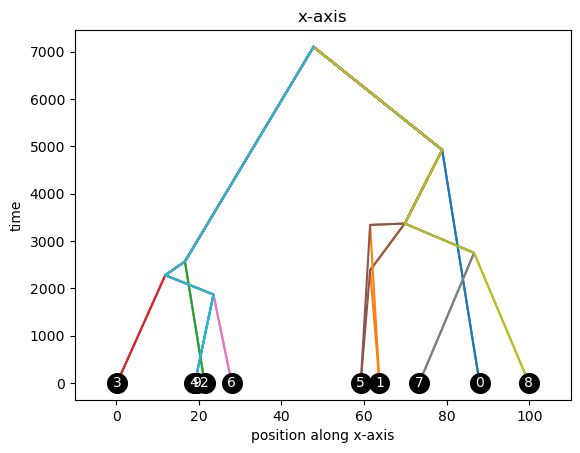

In [5]:
for tree in ts_simple.trees():

    for sample in ts_simple.samples():
    
        node = sample
        
        x_positions = [locations[node][0]]
        y_positions = [locations[node][1]]
        times = [tree.time(node)]
    
        node = tree.parent(node)
        while node != -1:
            x_positions.append(locations[node][0])
            y_positions.append(locations[node][1])
            times.append(tree.time(node))
            node = tree.parent(node)
    
        plt.plot(x_positions, times)
        
        
for sample in ts_simple.samples():
    plt.scatter(locations[sample][0], ts_simple.node(sample).time, s=200, color="black", zorder=2)
    plt.annotate(sample, (locations[sample][0], ts_simple.node(sample).time), ha="center", va="center", color="white")

plt.title("x-axis")
plt.xlabel("position along x-axis")
plt.ylabel("time")
plt.xlim(-10, 110)
plt.show()

Looking at the x-axis positions, you can see the power of a graph-based approach like this. Nodes that are found in multiple trees automatically take into account all of those local connections.

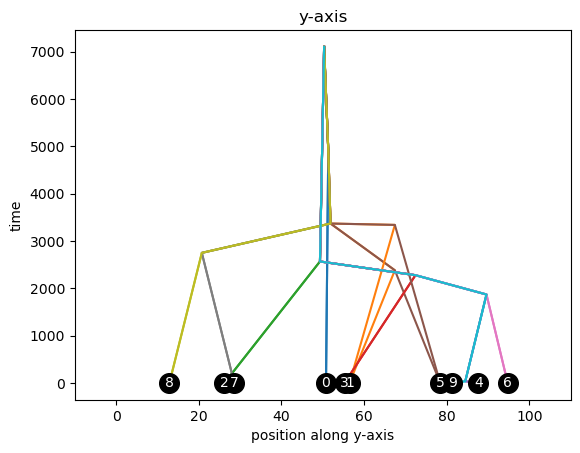

In [6]:
for tree in ts_simple.trees():

    for sample in ts_simple.samples():
    
        node = sample
        
        x_positions = [locations[node][0]]
        y_positions = [locations[node][1]]
        times = [tree.time(node)]
    
        node = tree.parent(node)
        while node != -1:
            x_positions.append(locations[node][0])
            y_positions.append(locations[node][1])
            times.append(tree.time(node))
            node = tree.parent(node)
    
        plt.plot(y_positions, times)
        
        
for sample in ts_simple.samples():
    plt.scatter(locations[sample][1], ts_simple.node(sample).time, s=200, color="black", zorder=2)
    plt.annotate(sample, (locations[sample][1], ts_simple.node(sample).time), ha="center", va="center", color="white")

plt.title("y-axis")
plt.xlabel("position along y-axis")
plt.ylabel("time")
plt.xlim(-10, 110)
plt.show()

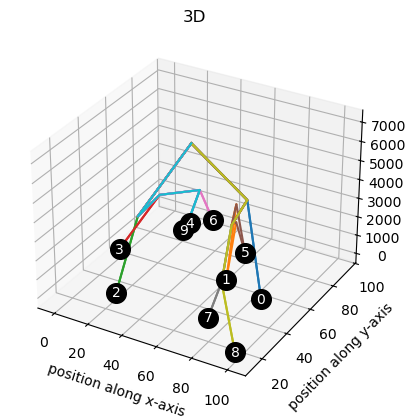

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for tree in ts_simple.trees():

    for sample in ts_simple.samples():
    
        node = sample
        
        x_positions = [locations[node][0]]
        y_positions = [locations[node][1]]
        times = [tree.time(node)]
    
        node = tree.parent(node)
        while node != -1:
            x_positions.append(locations[node][0])
            y_positions.append(locations[node][1])
            times.append(tree.time(node))
            node = tree.parent(node)
    
        ax.plot(x_positions, y_positions, times)
        
        
for sample in ts_simple.samples():
    ax.scatter(locations[sample][0], locations[sample][1], 0, s=200, color="black")
    ax.text(locations[sample][0], locations[sample][1], 0, sample, zorder=20, ha="center", va="center", color="white")


plt.title("3D")
plt.xlabel("position along x-axis")
plt.ylabel("position along y-axis")
plt.xlim(-10, 110)
plt.show()

Position estimates only take into account connections below them; this method does not recognize that deeper connections should influence the positions of nodes.